# Graph Representation Learning practicum

During this practicum we will teach you basic graph handling in Python using packages such as NetworkAnalysis and [NetworkX](https://networkx.org/documentation/stable/index.html) and how to perform Graph Representation Learning (GRL) using both shallow and deep encoders, as seen in the lecture. We will combine 2 main GRL tasks with 2 well known deep learning frameworks often used in industry and academia: 
1. Link Prediction on PPI graphs using a shallow encoder written in [Keras](https://keras.io/)/[Tensorflow](https://www.tensorflow.org/)
2. Node Classifiction on a citation network (Cora) using a Graph Convolution Network (GCN) written in [PyTroch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/).

It is important to understand the fundamental differences between shallow and deep encoders as well as their advantages/disadvantages. 


#### 1. Installing the environment
First we need to install the relevant packages, copy paste the following commands in the terminal :
```
conda create -n grl_prac python=3.9
conda activate grl_prac
pip install NetworkAnalysis
pip install OpenNe
pip install gensim
pip install tensorflow_ranking
pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
pip install torch_geometric
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
```

In [3]:
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import torch

from keras.models import Model
from keras.layers import Embedding, Input, Dense, Dropout, Lambda
from sklearn.metrics import roc_auc_score, average_precision_score
from NetworkAnalysis.UndirectedInteractionNetwork import UndirectedInteractionNetwork


#### 2. Zachary Karate Club
The [zachary karate club network](http://konect.cc/networks/ucidata-zachary/) is a well known toy-example to illustrate basic GRL methods and it's ideal to get a feeling of how to handle graphs in python. It was constructed during a survey of university karate club that had two teachers, in this network nodes represent student and edges represent some type of relationship between them. However, at a certain point the teachers got into a heated argument that divided the class into a number of groups. It is now your task to visualise these groups on the original network and subsequently embed this network using a shallow encoder while still maintaining this group structure. Below is some code to help you get started, feel free to dig into the `UndirectedInteractionNetwork` class as there are many function that could be helpful in obtaining basic network information. 

In [ ]:
# Read in network
karate_nw = pd.read_csv("data/karate.txt", sep=' ', header=None, names=['GeneA', 'GeneB'])
print(karate_nw.head())

In [ ]:
# We will use the UndirectedInteractionNetwork class from the NetworkAnalysis package to represent and manipulate the graph
karate_obj = UndirectedInteractionNetwork(karate_nw, keeplargestcomponent=True)

# Print out some basic information such as number of edges, nodes, is it directed etc.



In [ ]:
# We will use the Louvain algorithm to obtain the communities, note that the resolution parameter dictates the size of the groups: <1 = larger groups, >1 = smaller groups. Details on this algorithm can be found here but are not required for this practicum: https://arxiv.org/abs/1410.1237

communities = nx.community.louvain_communities(karate_obj.getnxGraph(), resolution=1, seed=23)
comm_dict = {f"group_{i}": c for i, c in enumerate(communities)}
comm_dict = {i:k for k, v in comm_dict.items() for i in v}

# Construct a colormap for however many groups you create
color_map = {"group_0": "blue", "group_1": "red", "group_2": "green", "group_3": "purple"}

In [ ]:
# Visualize the network using the function 'visualize' from the class object

karate_obj.visualize(show_labels=True,
                     node_colors=[color_map[comm_dict[gene]] for gene in karate_obj.getnxGraph().nodes], cmap='spectral',
                     title="Karate Communities",
                     color_scheme_edges=('gray', 'tab:green'),
                     labels_dict=None,
                     filename=None,
                     save_path=None)

##### 2.1 Shallow encoders: DeepWalk
An excellent example and one of the methods that laid the groundwork for GRL is [DeepWalk](https://arxiv.org/abs/1403.6652) introduced in 2014 by Perozzi et al. This method builds upon another very well known embedding method in the Natural Language Processing (NLP) field namely [word2vec](https://arxiv.org/abs/1301.3781). In word2vec the idea was to embed words into a latent space where similar words were situated close together. It did this by predicting the context of any given input word, meaning the likelihood of seeing any word (from the corpus of text) next to the input word. Hence, the input for word2vec was a specific word with it's context. For example, if we had a sentence:  
>'The **sheep** jumped the fence',
  
and our input word is **sheep** and our window size 1, the input would be 'the **sheep** jumped. Similarly to this, DeepWalk employs a random walker across the input graph generating *sentences* of nodes that will be used to train DeepWalk. This random walk has 2 optimizable parameters: (1) walk length and (2) number of walk per node. DeepWalk samples starting nodes from a uniform distribution, meaning that each node has the same probability to be chosen a seed node. Then, it employs a Depth First Search (DFS) sampling strategy illustrated in Figure 1. Here, no restricting is placed on the random walker to stay close to the seed node, this strategy captures community-structures present in the graph. Finally, like word2vec the probability of seeing nodes close to the seed node will be optimized such that topology of the input graph is embedded into the node representations


<figure>
  <center><img src="img/BFS_DFS.png"></center>
  <center><figcaption>Figure 1: Depth First Search (DFS) vs Breath First Search (BFS) (Perozzi et al. 2014)</figcaption></center>
</figure>

In [ ]:
# Use one of the shallow encoding methods from OpenNe (https://github.com/thunlp/OpenNE) to embed the graph. An example with DeepWalk is provided, if there is time left you can try other methods. 
karate_obj.list_embedding_methods()

# Embed the graph and construct a dataframe for visualization 
embeddings = karate_obj.generateEmbeddings(method='DeepWalk', dimensions=2, epochs=10)

df = pd.DataFrame(embeddings, index=['dim1', 'dim2']).transpose()
df['group'] = [comm_dict[gene] for gene in df.index]
print(df.head())


In [ ]:
# Visualize the embedded graph occording to each node's original group and compare with the original network. 

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.scatterplot(data=df, x='dim1', y='dim2', hue='group', ax=ax1, palette=color_map, s=100)
for i in range(df.shape[0]):
 ax1.text(x=df.dim1[i]+0.01,y=df.dim2[i]+0.01,s=df.index[i], 
          fontdict=dict(color='black',size=10))
ax1.set_title("Embeddings of karate network")
plt.show()

#### 3. Link Prediction on PPI scaffold
Now that we have seen that even shallow encoders are capable of encoding the topology of (small) graphs into an embedding space let's look at another shallow encoder although this time with many more non-linear transformations, i.e. a Multi Layer Perceptron (MLP). Due to the added non-linearities these types of encoders might be better at capturing more complex, less-obvious graph-structures that for example DeepWalk. For this part of the practicum we will use a publicly available interactome from [Reactome](https://reactome.org/download-data) in which nodes represent genes and edges interactions between genes. Note that, these interactions include but are not limited to physical interactions, metabolic interactions and others. 

##### 3.1 Edge sampling techniques
Unlinke with the karate club network where we let DeepWalk see the entire graph we now want to assess our model's ability to predict interaction between nodes that is has never seen before. As in classical machine learning we thus need to construct a set of edges to train on and a set of edges to test our performance on. However we can't just randomly divide all the positive edges in train and test, think about why this is not a valid option?

Figure 2 gives a hint towards the solution ...
<figure>
  <center><img src="img/mst.png" width="400" height="400"></center>
  <center><figcaption>Figure 2: Minimmum Spanning Tree of a random network [wikipedia](https://en.wikipedia.org/wiki/Minimum_spanning_tree)</figcaption></center>
</figure>

Another important aspect to take into account is the construction of negative samples. What would represent a negative sample in the case of a PPI network and how can we sample this? Also, how many negatives would it take to represent the actual situation, is it wise to sample this many or do we need a separate hyperparameter for this?



The generation of negative samples and the number of negative samples is extremely application dependent and requires some attention as the model is only as good as the positive and negative samples you provide, remember garbage in = garbage out.

In [4]:
reactome = pd.read_csv("data/reactome.txt", header=0, sep=None)
print(reactome.head())

reactome_obj = UndirectedInteractionNetwork(reactome, keeplargestcomponent=False)

mst_reactome = reactome_obj.getMinimmumSpanningTree()
print(len(mst_reactome))

# Otherwise training will take too long
pos_edges = set([tuple(i) for i in reactome_obj.getInteractionNamed().values]) - set(mst_reactome)
final_edges = mst_reactome + random.sample(list(pos_edges), k=25_000)
reactome_reduced_obj = UndirectedInteractionNetwork(pd.DataFrame(final_edges))

# X_train, X_test, Y_train, Y_test, summary_df = reactome_reduced_obj.getTrainTestData(train_ratio=0.8, neg_pos_ratio=5, 
#                                                                             train_validation_ratio=None, excluded_sets=None,
#                                                                             return_summary=True, random_state=42, balanced=False,
#                                                                             include_negatives=None, verbose=True)

X_train, X_test, Y_train, Y_test, summary_df = reactome_obj.getTrainTestData(train_ratio=0.8, neg_pos_ratio=5, 
                                                                            train_validation_ratio=None, excluded_sets=None,
                                                                            return_summary=True, random_state=42, balanced=False,
                                                                            include_negatives=None, verbose=True)


/tmp/ipykernel_28132/728848541.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  reactome = pd.read_csv("data/reactome.txt", header=0, sep=None)


    Gene1    Gene2                    Annotation Direction  Score
0  16-5-5    CDC42                     predicted         -   0.97
1  16-5-5    PARD3                     predicted         -   1.00
2  16-5-5   PARD3B                     predicted         -   1.00
3    A1CF  APOBEC1  catalyzed by; complex; input        <-   1.00
4    A1CF    EP300       expression regulated by        <-   1.00
Continuing with Gene1 and Gene2 as columns for the nodes
13953 Nodes and 257629 interactions
13868
13953 Nodes and 38868 interactions
Using unbalanced sampling



##### 3.2 Model architecture
We will use the Keras framework to write and train our model. While MLPs might be more powerful in detecting patterns they also are mcuh more difficult to train and have many more hyperparameters than other, non-deep learning methods, here are listed only a few of the paramters that are most often optimized: 
1. Number of hidden layers
2. Number of neurons per hidden layer
3. Type of hidden layer
4. Activation function
5. Loss functions
...

To guide you we have outlined a possible architecture in Figure 3. Try and replicate this architecture using Keras code (some code is there to help you on your way). Note that this is only an indication, you are free to choose the architecture yourself but keep in mind, the more complex it becomes, the longer it takes to train and thus the longer you will have to stay in this practicum ...

<figure>
  <center><img src="img/architecture.png"></center>
  <center><figcaption>Figure 3: Architecture of a dense multi-layer feedforward network, including one embedding layer. (Strybol 2019)</figcaption></center>
</figure>

Note that there is one *layer* not visualized in Figure 3 but essential **specifically** for link prediction. Can you guess what is missing?

In [5]:
# Define model parameters
N_nodes = reactome_obj.N_nodes
seq_length = 2
embed_dim = 10
hidden_nodes = 32
dropout = 0.2
final_activation = 'sigmoid'

# Define model architecture
embedding_layer = Embedding(input_dim=N_nodes, output_dim=embed_dim, input_length=seq_length, name='Embedder')
sequence_input = Input(shape=(seq_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
edge_rep = Lambda(lambda x:  x[:, 0] * x[:, 1], output_shape=[embed_dim], name='edge_representation')(embedded_sequences)

x = Dense(hidden_nodes, activation='relu')(edge_rep)
x = Dropout(dropout)(x)
x = Dense(hidden_nodes, activation='relu')(x)
x = Dropout(dropout)(x)
preds = Dense(1, activation=final_activation)(x)

# Declare model in Keras and print the model 
model = Model(inputs=sequence_input, outputs=preds)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 Embedder (Embedding)        (None, 2, 10)             139530    
                                                                 
 edge_representation (Lambda  (None, 10)               0         
 )                                                               
                                                                 
 dense (Dense)               (None, 32)                352       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                             

In [6]:
# Now we will train the model
loss = tf.keras.losses.binary_crossentropy
metrics = tf.keras.metrics.binary_accuracy
optimizer = tf.optimizers.Adam()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [7]:
n_epochs = 10
validation_split = 0.2
batch_size = 32
verbose = 1
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=0, mode='auto')

idx = np.random.permutation(Y_train.shape[0])
X_train = X_train[idx]
Y_train = Y_train[idx]
history = model.fit(x=X_train, y=Y_train, epochs=n_epochs, validation_split=validation_split, batch_size=batch_size, verbose=verbose, callback=[earlyStopping])

Epoch 1/10
30916/30916 [==============================] - 107s 3ms/step - loss: 0.2851 - binary_accuracy: 0.8986 - val_loss: 0.1824 - val_binary_accuracy: 0.9338
Epoch 2/10
30916/30916 [==============================] - 106s 3ms/step - loss: 0.1624 - binary_accuracy: 0.9428 - val_loss: 0.1531 - val_binary_accuracy: 0.9464
Epoch 3/10
30916/30916 [==============================] - 106s 3ms/step - loss: 0.1364 - binary_accuracy: 0.9521 - val_loss: 0.1462 - val_binary_accuracy: 0.9492
Epoch 4/10
30916/30916 [==============================] - 107s 3ms/step - loss: 0.1236 - binary_accuracy: 0.9568 - val_loss: 0.1425 - val_binary_accuracy: 0.9507
Epoch 5/10
30916/30916 [==============================] - 107s 3ms/step - loss: 0.1144 - binary_accuracy: 0.9601 - val_loss: 0.1424 - val_binary_accuracy: 0.9516
Epoch 6/10
30916/30916 [==============================] - 106s 3ms/step - loss: 0.1084 - binary_accuracy: 0.9623 - val_loss: 0.1407 - val_binary_accuracy: 0.9526
Epoch 7/10
30916/30916 [====

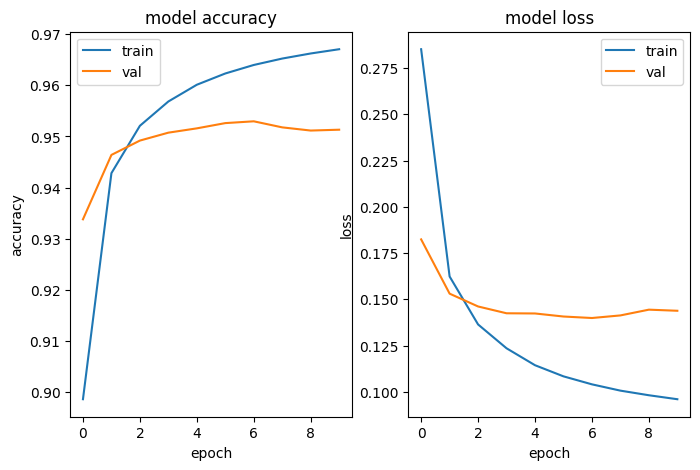

In [13]:
# Plot (val) loss and (val) binary accuracy and assess if the curves are correct
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))

ax1.plot(history.history['binary_accuracy'])
ax1.plot(history.history['val_binary_accuracy'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper right')
plt.show()

Could explain why the validation loss is lower at the start of training?

In [ ]:
test_preds = model.predict(X_test)
auc, ap = roc_auc_score(y_true=Y_test, y_score=test_preds), average_precision_score(y_true=Y_test, y_score=test_preds)
print(f"Prediciton performance on test set: {auc*100:.3f} AUC - {ap*100:.3f} Average Precision")

#### 4. Node classification using GCNs
Link prediction is more than just randomly sampling edges and mindlessly throwing it through a MLP, same goes for node classfification with deep encoders, in this case we will implement a Graph Convolution Network (GCN) in PyTorch geometric. These exercises are based on the [google collab](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing) by PyTorch geometric<sup>ref</sup>.

For this exercise we deviate (slightly) from the bioscience domain into the literature domain and make use of the [Cora citation network](https://graphsandnetworks.com/the-cora-dataset/). In this network nodes represent publiations characterized by a bag-of-words vector and edges represent when one publication cites the other. Furthermore, each publication is classified into one of 7 categories. Hence, contrary to the PPI network where we only had topological information, we now have features describing each node and node labels. Your task is now to build a GCN that is able to classify each publication in the correct category assuming only part of the network is labeled, this is called semi-supervised deep learning. 


In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

# Print information about the graph 
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Is undirected: {data.is_undirected()}')

# Think about the size of the feature matrix and adjancency matrix and check by printing the data object
print(data)

# Print a part of the feature matrix
data.x


Now we see that the object contains all the relevant information, in addition to the basics is contains a `val_mask` and a `test_mask`, these masks highlight the nodes that we will use for validation and testing respectively.
Before we start building the model take some time to analyze the feature matrix, note that the original features are bag-of-words (BOW) vectors for each. This means that each featurer is a word and thus $x_{ij}$ represent the number of times $word_{j}$ occurs in $publication_i$ (or $sample_i$). Often in ML or DL when gradient descent (GD) algoritms are used to optimze the objective function, GD will converge faster if all features have the same scale, i.e. are normalized. Check how the feature matrix is normalized and reason why this is done a particular way and identify the function in pytorch geometric that could perform this operation.

##### 4.1 Graph Convolution Network
Below you find starting code to build the GCN from the ground up, PyTorch lends itself more to OOP as compared to keras which is why we now stash all functions in a class. For pytorch it is necessary to both declare the network as well as a `forward` function. The latter dictates the order in which the input should flow through the model. There are 2 main ways to encode this, either using pytorch geometric `torch_geometric.nn.Sequential` (more dificult) where the order is already specified in the Sequential module or you can leave out this module and specificy the order in the `forward` pass.
These elements should be present in your model:
1. a GCNconv layer
2. a dropout layer
3. an activation function

Also, keep in mind that later on we will want to visualize our embeddings so be sure to either return your embeddings or write a function such that you can obtain your embeddings after training. What is the difference between these options?

In [ ]:
import torch_geometric.nn as geom_nn
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, in_features, hidden_features, out_features, **kwargs):
        super().__init__()

        # Define GCN layers

        self.gcn1 = geom_nn.GCNConv(in_channels=in_features, out_channels=hidden_features, **kwargs) # add self loops default true
        self.gcn2 = geom_nn.GCNConv(in_channels=hidden_features, out_channels=out_features, **kwargs)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # layer 1
        x= self.gcn1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # layer 2
        output = self.gcn2(x, edge_index)

        return output

Now that we have build the model we can start defining the training and testing loop. As explained in the course notes the training loop must consist of:
1. A forward pass
2. Loss calculation
3. A backward pass
4. An update of the model weights

Note one peculiarity in the testing loop: `model.eval()`, why is this neceassary and what is it's effect on the model?

In [ ]:
model = GCN(in_features=data.x.shape[1], hidden_features=16, out_features=dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


Before we train the model we want to get an understanding if their is already some structure present in the basic graph or not at all, visualize the unlearned embeddings by passing the input through the model for 1 step. Then, use a dimensionality reduction technique of your choice (UMAP, PCA, TSNE) to plot the embeddings in 2D and color each node occording to it's assigned category.

In [ ]:
# Visualize the embeddings colored by category
from sklearn.manifold import TSNE

# 1. Get all categories 
categories = model(data).argmax(dim=1).detach().numpy()

# 2. Perform TSNE on the embeddings 
tsne_ = TSNE()
dims = tsne_.fit_transform(model(data).detach().numpy())

# 3. Put everyting together in a dataframe
cora_df = pd.DataFrame({"dim1":dims[:, 0], "dim2":dims[:, 1], "group":categories})

# 4. Plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.scatterplot(data=cora_df, x='dim1', y='dim2', hue='group', palette=sns.color_palette('tab10'), ax=ax1, s=50)
ax1.set_title("Embeddings of Cora network")
plt.show()

In [ ]:
# Train the model

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Test the model
test_acc = test()
print(f"Testing accuracy is {test_acc*100:.2f}%")

In [ ]:
# Visualize the embeddings colored by category

# 1. Get all categories 
categories = model(data).argmax(dim=1).detach().numpy()

# 2. Perform TSNE on the embeddings 
tsne_ = TSNE()
dims = tsne_.fit_transform(model(data).detach().numpy())

# 3. Put everyting together in a dataframe
cora_df = pd.DataFrame({"dim1":dims[:, 0], "dim2":dims[:, 1], "group":categories})

# 4. Plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
sns.scatterplot(data=cora_df, x='dim1', y='dim2', hue='group', palette=sns.color_palette('tab10'), ax=ax1, s=50)
ax1.set_title("Embeddings of Cora network")
plt.show()